
# Training CIFAR10 classifier
Disclaimer: This notebook is an adopted version of [this tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).
<img src="static/cifar10.png" align="center"/>

This is it! You have seen how to define neural networks, compute loss and make updates to the weights of the network. Today we'll train CIFAR10 classifier in 2 modes:
1. train model from scratch
2. finetune pretrained model

But before start, let's understand what CIFAR10 dataset is.

**CIFAR10** - 10-class dataset of 32x32 RGB images. The main difference from MNIST is that in CIFAR10 images have 3 channels (RGB). CIFAR10 images are downscaled photos of **real** objects:  `airplane`, `automobile`, `bird`, `cat`, `deer`,
`dog`, `frog`, `horse`, `ship`, `truck`.

## Task 1 (2 points). Train model from scratch
We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the validation data



### 1. Loading and normalizing CIFAR10
Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Parameters:

In [2]:
batch_size = 4
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

CIFAR10 classes:

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range ~[-1, 1]. This weird numbers are just means and stds calculated on ImageNet (check [this docs](https://pytorch.org/docs/master/torchvision/models.html) for more information). **Why should we normalize images?**

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Setup dataloaders (downloading CIFAR10 can take some time):

In [5]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print("len(train_dataset) =", len(train_dataset))

val_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("len(val_dataset) =", len(val_dataset))

Files already downloaded and verified
len(train_dataset) = 50000
Files already downloaded and verified
len(val_dataset) = 10000


Let us show some of the training images, for fun:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape = torch.Size([4, 3, 32, 32])
labels = tensor([9, 6, 5, 0])
labels.shape = torch.Size([4])


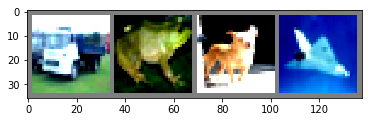

truck  frog   dog plane


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = img.cpu().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_dataloader))

print("images.shape =", images.shape)

print("labels =", labels)
print("labels.shape =", labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Define a Convolutional Neural Network
Here we'll define convolutional neural network. Below you can find scheme of network. Implement it using PyTorch:

1. Conv (3 -> 6, 5x5, stride=1, padding=`same`)
2. ReLU
3. MaxPool (2x2, stride=2)
4. Conv (6 -> 16, 5x5, stride=1, padding=`same`)
5. ReLU
6. Linear (`???` -> 128)
7. ReLU
8. Linear (128 -> 64)
9. ReLU
10. Linear (64 -> 10)

Here padding=`same` means that the size of image doesn't change, so you have to calculate padding value yourself. Also you can see unknown `???` in 6th layer (calculate it yourself or find it emperically).

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        ## define layers here
        self.layer_1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.layer_2 = nn.ReLU()
        self.layer_3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.layer_4 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.layer_5 = nn.ReLU()
        self.layer_6 = nn.Linear(in_features=16 * 16 * 16, out_features=128)
        self.layer_7 = nn.ReLU()
        self.layer_8 = nn.Linear(in_features=128, out_features=64)
        self.layer_9 = nn.ReLU()
        self.layer_10 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        
        ## code forward pass here
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = x.view(-1, 16 * 16 * 16)
        x = self.layer_6(x)
        x = self.layer_7(x)
        x = self.layer_8(x)
        x = self.layer_9(x)
        x = self.layer_10(x)
        
        return x


model = SimpleConvNet().to(device)

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting. We simply have to loop over our dataloader, and feed the inputs to the
network and optimize.

In [12]:
from tqdm import tqdm_notebook as tqdm

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model(image_batch)
        loss = criterion(outputs, label_batch)
        
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
        
    print("[epoch {}] loss: {:.3}".format(epoch, running_loss / len(train_dataloader)))


[epoch 0] loss: 1.56



[epoch 1] loss: 1.21


### 5. Test the network on the validation data

We have trained the network for 2 epochs over the training dataset. But we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the validation set to get familiar.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


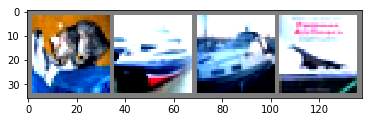

GroundTruth:    cat  ship  ship plane


In [13]:
image_batch, label_batch = next(iter(val_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

# print images
imshow(torchvision.utils.make_grid(image_batch))
print('GroundTruth: ', ' '.join('%5s' % classes[label_batch[j]] for j in range(batch_size)))

Okay, now let us see what the neural network thinks these examples above are:



In [14]:
outputs = model(image_batch)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [15]:
predicted = torch.argmax(outputs, dim=1)

print("Predicted: {}".format(" ".join(classes[predicted[j]]for j in range(batch_size))))

Predicted: cat ship ship ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [18]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()

print("Accuracy of the network on the 10000 val images: {:.4}%".format(100 * correct / total))


Accuracy of the network on the 10000 val images: 59.34%


That looks waaay better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something. You're awesome.

## Task 2 (2 points). Finetune pretrained model

As we already know, **deep learning** is about hierarchical feature learning. It means that major part of neural network just learns how to extract features, and only last layers laearn how to solve target task (e.g. classification). So if we take some modern model carefully trained on a big dataset, it's likely that it has learnt to extract some useful features from data.

In this part of the seminar, we'll finetune [AlexNet](https://arxiv.org/abs/1404.5997) (one of the first deep CNN-architectures) trained on ImageNet (1000-class image dataset).

We'll do following steps:
1. Load and initialize the pretrained model
2. Freeze part of the network responsible for extracting *features*
3. Replace existing *classifying* part of the network with yours
4. Finetune resulting model

As you can read in the [AlexNet paper](https://arxiv.org/abs/1404.5997), takes images of size 224x224. Add proper resize to our transforms:

In [19]:
transform = transforms.Compose([
    ## <- add resize here
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Setup dataloaders (the same as before, but with different transform):

In [20]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print("len(train_dataset) =", len(train_dataset))

val_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("len(val_dataset) =", len(val_dataset))

Files already downloaded and verified
len(train_dataset) = 50000
Files already downloaded and verified
len(val_dataset) = 10000


### 1. Load and initialize the pretrained model

Now let's load already pretrained AlexNet model. Luckily `torchvision` gives us easy interface to load popular pretrained models (weights downloading can take some time): 

In [21]:
model = torchvision.models.alexnet(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /Users/konstantinivanov/.torch/models/alexnet-owt-4df8aa71.pth
244418560it [00:16, 14872525.33it/s]


Look at [source code](https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py) for AlexNet for deeper understanding of how model works. Let's print it:

In [22]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

As we can see, AlexNet has 2 main submodules:
 - **features**: extracts high-abstract features from input images
 - **classifier**: classifies resulting features in 1000 ImageNet classes
 
`features` module is very useful for us, and we'll use it as it is. `classifier` module is more specific for ImageNet classes and we'll replace it with our own.

We don't want to finetune `features` module, so let's freeze it by setting `requiers_grad=False` to its parameters:

In [35]:
## iterate over parameters and freeze them
for param in model.features.parameters():
    param.requires_grad = False

Now let's build our own classifier. Use [nn.Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential) for simplisity. Also try using [nn.Dropout](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) just as in original model:

In [49]:
classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=1000),
)

Replace existing classifier with ours:

In [50]:
model.classifier = classifier

Setup criterion and optimizer.

**Note**: we pass to optimizer only those parameters that we want to optimize.

In [38]:
criterion = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

Run training for only 1 epoch:

In [52]:
## you code here (you can just copy-paste from code above)
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    running_iters = 0
    for i, batch in enumerate(train_dataloader):
        if (i > 0) & (i%100 == 0):
            print(i)
        # get the inputs
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model(image_batch)
        loss = criterion(outputs, label_batch)
        
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        running_iters += 1
        
        if i == 1000:
            break
        
        
    print("[epoch {}] loss: {:.3}".format(epoch, running_loss / running_iters))

100
200
300
400
500
600
700
800
900
1000
[epoch 0] loss: 7.15


Validate:

In [53]:
## you code here (you can just copy-paste from code above)
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        if (i > 0) & (i%100 == 0):
            print(i)
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()
        
        if i == 1000:
            break

print("Accuracy of the network on the 4000 val images: {:.4}%".format(100 * correct / total))

100
200
300
400
500
600
700
800
900
1000
Accuracy of the network on the 4000 val images: 0.07493%


WOW! We seriously improved accuracy of our model by just finetuning several linear layers. Here is the power of finetuning!